# Efficient GANの概要
効率的なMNISTの画像異常検知を行う

## Efficient GAN
ノイズ$z$を反復手法で求めず，画像からノイズを得るエンコーダEを構築する  
要は，画像を入力，ノイズを出力とするDLモデルを構築すれば良い  
EはGANと一緒に学習させないとうまくいかないことが経験的に知られている

## Eの作成と後から作ってもうまくいかない理由
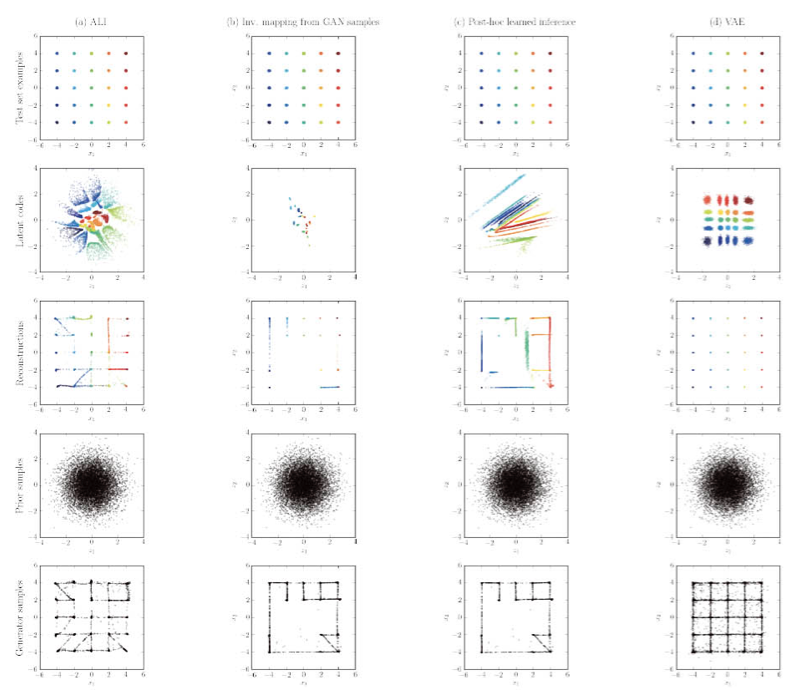

横は左から
- GANとEを一緒に学習させた結果
- 後からEをAutoencoder風に学習させた結果
- 読み飛ばしてください
- EをVAEで学習させた結果
    
要は，GANとEを一緒に学習させるのが一番いいですよという結果を示している  

縦は上から
- 元となる二次元データ(混合ガウス分布), 各列同じ
- それぞれのEでzに変換したデータ
- 読み飛ばしてください
- zの分布
- zによる再構成結果(VAEはGではなくデコーダ)

GANの入力データ$z$は平均0偏差1の分布を仮定している  
そのため,Eで変換した$z$は4行目のような形になっていてほしい  
GANによる$z$が一番それっぽい形になっている．  
  
さらに，ノイズは綺麗にクラスごとに分離されており，かつ隙間がないことが望ましい  
重なっているところがあれば「2と8の間」のような中途半端なデータができてしまう  
隙間があれば存在しないデータが生まれてしまう．  
この条件をうまく満たしているのもGANとEによるものである．  
  
再構成結果である5行目を見てみる．  
AutoEncoderでは一部のデータが消えてしまっている  
VAEでは元のデータに存在しない線が出現してしまっている．  
GANによるものが比較的最もうまく再構成できている．  
  
以上のように，実験的に，GANによるノイズ$z$の生成はAutoEncoderやVAEに比べて良い結果を出せることがわかる．

後からEを作る作戦がうまくいかないのはなぜか．  
Gは基本的に理想的なデータ生成ができない．  
この完璧でない$G(z)=x'$で$E=G^{-1}$を作っても，$E(x)\neq z$である．  
結果，完璧でないGを使ってあとからEを作っても元の$z$の分布を再現できない．  
  
Eを作る際はGANの学習時に使用する教師データ$x$も使用する必要がある

## EをGANと同時に作る方法
まず，GANの目的関数を再掲  
$$ \sum_{i=1}^M [ l_i \log D(x) + (1 - l_i) \log(1-D(G(z))) ] $$

Eを教師データの画像$x$と関与させるため，Bidirectional GAN, BiGANを利用  
BiGANでは，Dに$(x, z)$を入力し，$(x,E(x))$が入力されたのか，$(G(z), z)$が入力されたのかを識別させる．  
Efficient GANは，このBiGANの仕組みを異常検知に使用する．  
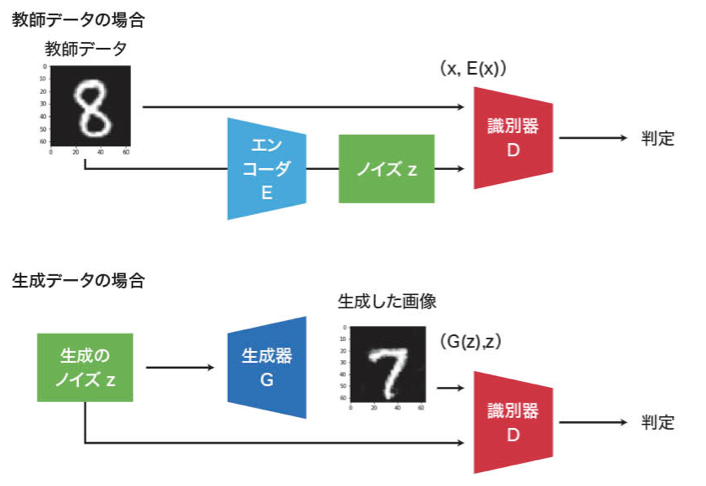

DとGの損失関数は，通常のGANにノイズが加わっただけのものになる  
D: $$ - \sum_{i=1}^M \log D(x_i, E(x_i)) - \sum_{j=1}^M \log (1-D(G(z_j), z_j)) $$
G: $$ - \sum_{j=1}^M \log D(G(z_j), z_j) $$

EはDの損失関数を最大化すれば良いので  
$$ \sum_{i=1}^M \log D(x_i, E(x_i)) \sum_{j=1}^M \log (1-D(G(z_j), z_j)) $$
ここで第2項はEに関与しないので  
$$ \sum_{i=1}^M \log D(x_i, E(x_i)) $$
が最小化対象の損失関数となる．  
しかし，これもGと同様，学習初期はDに見破られやすい問題がある  
見破られると,誤差$\log 1 = 0$となり，損失が0になりやすく学習が進みづらい  
そこでEは引き算を利用して次のように書き換える  
$$ - \sum_{i=1}^M \log ( 1 - D(x_i, E(x_i))) $$

Dを学習済みにしてからこの損失関数でEを学習させてもうまくいかない．  
学習済みのDはEで簡単に騙すことができず，損失が大きくなりすぎて学習が安定しないためである．  
そのため，DとEも同時に学習させる．

# Efficient GANの実装と以上検知の実施

論文に合わせ，(64,64)に拡大せず，(28,28)のままの画像データを作成する

In [1]:
import os
from sklearn.datasets import fetch_openml
from PIL import Image
import numpy as np

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import models, transforms
from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "../datasets/chapter6"
img_78_path = os.path.join(data_dir, "img_78_28size")
test_path = os.path.join(data_dir, "test_28size")

for path in [data_dir, img_78_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
# MNISTの手書き数字画像をダウンロードし読み込みます（2分ほど時間がかかります）
mnist = fetch_openml('mnist_784', version=1, data_home=data_dir)  

# データの取り出し
X = mnist.data
y = mnist.target

この画像データのラベルは5です


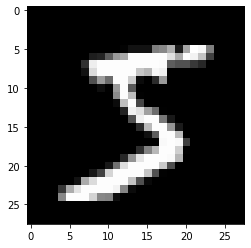

In [4]:
# ロードできてるか確認
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))

In [ ]:
# 時間短縮のため，7，8のみを扱うGANを作りたい．
# MNISTから数字7、8の画像だけフォルダ「img_78」に(64,64)PIL画像として保存していく
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path=os.path.join(img_78_path, f"img_7_{count7}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path=os.path.join(img_78_path, f"img_8_{count8}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count8+=1 

In [6]:
# 6章用テストデータも作成
count2=0
count7=0
count8=0
max_num=5

for i in range(2244,len(X)):
    
    # 画像2の作成
    if (y[i] is "2") and (count2<max_num):
        file_path=os.path.join(test_path, f"img_2_{count2}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count2+=1
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path=os.path.join(test_path, f"img_7_{count7}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path=os.path.join(test_path, f"img_8_{count8}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f.save(file_path)  # 保存
        count8+=1 

## GeneratorとDiscriminatorの実装


DCGANがベース

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        
        # 転置畳み込み層に入れるためテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        
        out = self.layer3(out)
        out = self.last(out)
        
        return out

Dは画像$x$に加え，ノイズ$z$も受け取るようにする

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.z_layer1 = nn.Linear(z_dim, 512)
        
        
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last2 = nn.Linear(1024, 1)
        
    def forward(self, x, z):
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)
        
        # x_outとz_outを結合し，全結合層で判定
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        # 最後の一つ手前の情報も返す(AnomaryLossあとで計算する)
        feature = out
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last2(out)
        
        return out, feature

## Encoderの実装

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        # ここまでで画像のサイズは(7,7)に圧縮されている
        self.last = nn.Linear(128 * 7 * 7, z_dim)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)
        
        return out

## DataLoaderの実装

In [6]:
def make_datapath_list():
    """
    学習，検証の画像データとアノテーションデータへのファイルパスリストを作成
    """
    
    train_img_list = []
    
    for img_idx in range(200):
        img_path=os.path.join(img_78_path, f"img_7_{img_idx}.jpg")
        train_img_list.append(img_path)
        
        img_path=os.path.join(img_78_path, f"img_8_{img_idx}.jpg")
        train_img_list.append(img_path)
    
    return train_img_list

In [7]:
class ImageTransform():
    """
    画像の前処理クラス
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        return img_transformed

In [8]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size()) # (M, C, H, W)

torch.Size([64, 1, 28, 28])


## Efficient GANの学習


In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

In [10]:
G = Generator()
E = Encoder()
D = Discriminator()

G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print(G, "\n", D, "\n", E)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=6272, bias=True)
    (1): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
) 
 Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Con

In [11]:
def get_device(benchmark=True):
    # GPUが使用可能ならば設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス: ", device)
    
    # ネットワークがある程度固定であれば，高速化できる
    torch.backends.cudnn.benchmark = benchmark
    
    return device

In [12]:
def train_model(G, D, E, dataloader, num_epochs, device=None):
    
    # Dに与えるヒントが増えるので，学習率を小さくした方がフェア
    lr_ge, lr_d = 0.0001, 0.0001 / 4
    beta1, beta2 = 0.5, 0.999
    z_dim = 20
    
    # 最適化手法
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])
    
    # 誤差関数
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # モデルの学習準備
    if device:
        G.to(device)
        D.to(device)
        E.to(device)
    G.train()
    D.train()
    E.train()
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 学習ループ
    iteration = 1
    logs = []
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_e_loss = 0.0
        epoch_d_loss = 0.0
                
        # データローダーからminibatch_sizeずつ取り出す
        for images in dataloader:
            
            # ミニバッチサイズが1だとBatchNormでエラーになるので避ける
            mini_batch_size = images.size()[0]
            if mini_batch_size == 1:
                continue
            
            
            #################
            # データの作成
            #################
            label_real = torch.full((mini_batch_size,), 1)
            label_fake = torch.full((mini_batch_size,), 0)
            input_d_z = torch.randn(mini_batch_size, z_dim)
            input_g_z = torch.randn(mini_batch_size, z_dim)
            
            # GPUが使えるならデータを渡す
            if device:
                images = images.to(device)
                label_real = label_real.to(device)
                label_fake = label_fake.to(device)
                input_d_z = input_d_z.to(device)
                input_g_z = input_g_z.to(device)

            
            #################
            # Discriminator
            #################
            
            # 本物の画像と偽物の画像を判定
            d_out_real, _ = D(images, E(images))
            d_out_fake, _ = D(G(input_d_z), input_d_z)
            
            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # 誤差逆伝搬
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            
            #################
            # Generator
            #################
            
            # 偽の画像を生成して判定
            d_out_fake, _ = D(G(input_g_z), input_g_z)
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # 誤差逆伝搬
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            #################
            # Encoder
            #################
            
            # 本物の画像のzを推定
            d_out_real, _ = D(images, E(images))
            
            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)
            
            # 誤差逆伝播
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            
            
            #################
            # 記録
            #################
            epoch_d_loss += d_loss.item()
            epoch_e_loss += e_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        
        if (epoch+1) % 100 == 0:
            clear_output()
            print("-----------------")
            print(f"Epoch {epoch+1}/{num_epochs}")
            print("-----------------")
            print(' (train) ')

        
            print("-----------------")

            d_loss = epoch_d_loss / batch_size
            g_loss = epoch_g_loss / batch_size
            e_loss = epoch_e_loss / batch_size
            print(f"epoch {epoch+1} | D loss: {d_loss} | E loss: {e_loss} | G loss: {g_loss}")

            t_epoch_finish = time.time()
            print(f"timer: {t_epoch_finish - t_epoch_start}")
            t_epoch_start = time.time()
    
    return G, D, E

学習を開始

In [13]:
device = get_device()
G_update, D_update, E_update = train_model(
    G=G,
    D=D,
    E=E,
    dataloader=train_dataloader,
    num_epochs=1500,
    device=device
)

-----------------
Epoch 1500/1500
-----------------
 (train) 
-----------------
epoch 1500 | D loss: 0.10002782102674246 | E loss: 0.13791375514119864 | G loss: 0.14932567719370127
timer: 0.2184154987335205


学習の結果

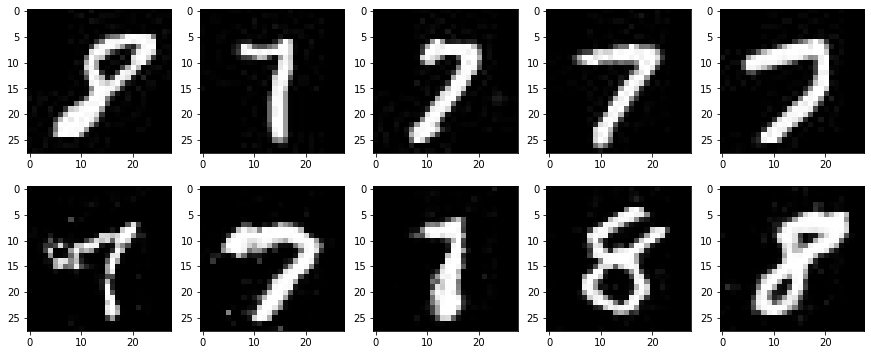

In [16]:
# 生成データ
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
if device: fixed_z = fixed_z.to(device)
fake_images = G_update(fixed_z)

# 本物データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 表示
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段は訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段は生成データ
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

## Efficient GANによる異常検知
AnomalyScoreの取得手順はAnoGANと同様  
しかし，Eに通して得たノイズ$z$をDに使用する

In [14]:
def anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    
    residual_loss = torch.abs(x - fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # エンコードされたノイズもいっしょにDへ与える
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

In [15]:
def make_test_datapath_list():
    train_img_list = list()
    for i in range(5):
        img_path = os.path.join(test_path, f"img_7_{i}.jpg")
        train_img_list.append(img_path)
        
        img_path = os.path.join(test_path, f"img_8_{i}.jpg")
        train_img_list.append(img_path)
        
        img_path = os.path.join(test_path, f"img_2_{i}.jpg")
        train_img_list.append(img_path)
        
    return train_img_list

テストデータを取得

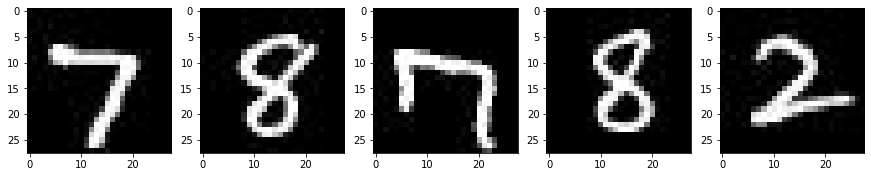

In [29]:
test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list,
    transform=ImageTransform(mean, std)
)

batch_size = 5
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# テストデータの確認
batch_iterator = iter(test_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

Eに画像を入力して得たノイズ$z$を用いて異常検知を行う

total loss: [174. 182. 265. 174. 210.]


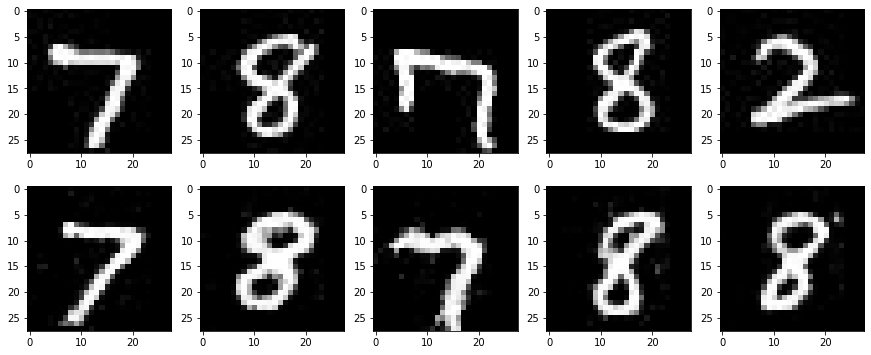

In [31]:
if device:
    images = images.to(device)

images = images[:5]
    
# テストデータの画像をEでエンコードし，Gで再生成
z_out_real = E_update(images)
images_reconstract = G_update(z_out_real)

# Anomaly Scoreを求める
loss, loss_each, residual_loss_each = anomaly_score(
    images, images_reconstract, 
    z_out_real, D_update, Lambda=0.1
)
loss_each = loss_each.cpu().detach().numpy()
print("total loss:", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(images_reconstract[i][0].cpu().detach().numpy(), 'gray')

真ん中のさすがに7?みたいなのは置いておくとすると，確かに2は200を超えるAnomaly Scoreになっており，異常として検知できる  
AnoGANの時とは違い，Eのお陰で反復的な$z$の作成が不要になっており，高速

この以上どの閾値をどこに設定するかは，偽陽性，偽陰性のバランスをとって設定する